# Galaxy Morphology EDA and Classification 
## By: Lauren Fisher and Logan Bayer

## Introduction 
With a simple SQL search targeting galatic morphologies and fluxes from galactic emission spectra from the [Sloan Digital Sky Survey](https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+zooSpec+U) (SDSS), one can amass a dataset with tens of thousands of instances. Sadly, in the heat of creating the SDSS dataset, someone (Logan) forgot to save the SQL query. However, such a query is easily reproducible. To save computing power, one can limit the number of instances to 20,000 before data cleaning. Following data cleaning, the number of instances drops to roughly 4,000. The main objective of classifying galatic morphologies using fluxes from the SDSS dataset is to improve the speed at which astronomers may parse through spectra. By testing classifiers such as kNN, Naive Bayes, Decision Tree, Random Forest, and Dummy, an accuracy test proves kNN to be the best classifier. Unfortunately though, kNN requires the most computational power, so the number of instances must drop to 2,000 for a reasonable computational time. 

## Data Analysis
To better understand the morphologies of galaxies, one must analyze the fluxes from the spectra of each galaxy while also maintianing the unique identifier of the galaxy. Hence, the presence of the long list of attributes. Yet, there are vital attributes such as the list of fluxes. For class labels, the multi-class labels reduce to a binary classification scheme of p_el and p_spiral (a combination of p_cw, p_acw, and p_edge).

### Attribute Values 
The following provides the a list of the attributes and their significance 
* specObjID (int): Spectrum object ID (unique identifier)
* plate (int): Plate number
* mjd (int): MJD of observation
* fiberID (int): Fiber ID
* class (str): Type of object
* p_el (float): Fraction of votes for elliptical galaxy
* p_cw (float): Fraction of votes for clockwise spiral galaxy
* p_acw (float): Fraction of votes for anticlockwise spiral galaxy
* p_edge (float): Fraction of votes for edge-on disk
* p_dk (float): Fraction of votes for don't know
* p_mg (float): Fraction of votes for merger
* ra (deg): Right ascension
* dec (deg): Declination
* z (float): Redshift of object 
* zWarning (int): Warnings for potential errors 
    * 0 - OK: no warnings 
    * 1 - SKY: sky fiber
    * 2 - LITTLE_COVERAGE: too little wavelength coverage (WCOVERAGE < 0.18)
    * 4 - SMALL_DELTA_CHI2: chi-squared of best fit is too close to that of second best (< 0.01 in reduced chi-sqaured)
    * 8 - NEGATIVE_MODEL: synthetic spectrum is negative (only set for stars and QSOs)
    * 16 - MANY_OUTLIERS: fraction of points more than 5 sigma away from best model is too large (> 0.05)
    * 32 - Z_FITLIMIT: chi-squared minimum at edge of the redshift fitting range (Z_ERR set to -1)
    * 64 - NEGATIVE_EMISSION: a QSO line exhibits negative emission, triggered only in QSO spectra, if C_IV, C_III, Mg_II, H_beta, or H_alpha has LINEAREA + 3 * LINEAREA_ERR < 0
    * 128 - UNPLUGGED: the fiber was unplugged, so no spectrum obtained
* waveMin (float): Minimum observed wavelength in angstroms 
* plateSN2 (float): Overall signal-to-noise-squared measure for plate (only set for SDSS spectrograph) 
* h_delta_flux (float): Flux from Gaussian fit to continuum subtracted data for $H$ at $\lambda = 4101.7$
* h_gamma_flux (float): Flux from Gaussian fit to continuum subtracted data for $H$ at $\lambda = 4340.5$
* oiii_4363_flux (float):  Flux from Gaussian fit to continuum subtracted data for $O^{+++}$ at $\lambda = 4363$
* h_beta_flux (float): Flux from Gaussian fit to continuum subtracted data for $H$ at $\lambda = 4861.4$
* oiii_4959_flux (float): Flux from Gaussian fit to continuum subtracted data for $O^{+++}$ at $\lambda = 4959$
* oiii_5007_flux (float): Flux from Gaussian fit to continuum subtracted data for $O^{+++}$ at $\lambda = 5007$
* hei_5876_flux (float): Flux from Gaussian fit to continuum subtracted data for $He^{+}$ at $\lambda = 5876$
* oi_6300_flux (float): Flux from Gaussian fit to continuum subtracted data for $O^{+}$ at $\lambda = 6300$
* h_alpha_flux (float): Flux from Gaussian fit to continuum subtracted data for $H$ at $\lambda = 6563$
* nii_6548_flux (float): Flux from Gaussian fit to continuum subtracted data for $N^{++}$ at $\lambda = 6584$
* sii_6717_flux (float): Flux from Gaussian fit to continuum subtracted data for $S^{++}$ at $\lambda = 6717$
* sii_6731_flux (float): Flux from Gaussian fit to continuum subtracted data for $S^{++}$ at $\lambda = 6731$

### Data Cleaning 
Recall, before cleaning, the SDSS dataset contains 20,000 instances. After removing unphysical fluxes (i.e. those fluxes below zero and above 10,000), the number of instances drops to roughly 4,000 instances. Further, the code below shows the snippet necessary for also removing any instance in which technical difficulties could occur (zWarning block). Also, since luminosities vary based on the distance of objects, one must normalize the fluxes relative to another flux. In our case, we use h_beta_flux. Please note that instances of data cleaning continue throughout the EDA process. 

In [6]:
# Import block for all packages
from utils.mypytable import MyPyTable 
import utils.plot_utils as plot_utils
import importlib
import utils.myclassifiers
importlib.reload(utils.myclassifiers)
from utils.myclassifiers import MyDecisionTreeClassifier
from utils.myclassifiers import MyKNeighborsClassifier
from utils.myclassifiers import MyDummyClassifier
from utils.myclassifiers import MyNaiveBayesClassifier
from utils.myrandomforestclassifier import MyRandomForestClassifier
import random

import utils.myevaluation
importlib.reload(utils.myevaluation)
import utils.myevaluation as myevaluation
from itertools import chain
import utils.myutils as utils
importlib.reload(utils)
importlib.reload(plot_utils)
table = MyPyTable()
file_name = 'Skyserver_SQL4_21_2022 12_41_18 AM.csv'
table.load_from_file('input_folder/' + file_name)

# Removing all the unphysical fluxes
def row_idx_flux(table, col_idxs):
    row_indexes = []
    
    for i in range(len(col_idxs)):
        for j in range(len(table)):
            if j not in row_indexes:
                if (table[j][col_idxs[i]] > (1*10**5)) or (table[j][col_idxs[i]] < 0):
                    row_indexes.append(j)

    return row_indexes

col_idxs = list(range(17, 28 + 1)) # Plus 1 to account for exclusivity (17 start of fluxes)

row_flux =  row_idx_flux(table.data, col_idxs) 
b_len = len(table.data)
table.drop_rows(row_flux)
a_len =len(table.data)

# Data Cleaning 
# Removing all zWarning that are not (0 - OK)
values, counts = utils.get_frequencies(table.data, 14)

def row_indexes_to_drop(table, col_idx): # Technically this should be in utils
    row_indexes = []
    row_indexes = [i for i in range(len(table)) if table[i][col_idx] != 0]

    return row_indexes

row_idxs = row_indexes_to_drop(table.data, 14)
b_len = len(table.data)
table.drop_rows(row_idxs)
a_len = len(table.data)
print(len(table.data))

# Flux normalization
for i in range(len(col_idxs)):
    for j in range(len(table.data)):
        table.data[j][col_idxs[i]] = table.data[j][col_idxs[i]] / table.data[j][col_idxs[3]] # 3 indicates index of h_beta_flux in col_idxs

4987


### Summary Statistics 
The following summary statistics provide insight into the columns listed in the code below:

In [7]:
summary_table = table.compute_summary_statistics(['p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'ra', 'dec', 'z', 'zWarning', 'waveMin', 'plateSN2', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux', 'h_alpha_flux', 'nii_6548_flux', 'sii_6717_flux', 'sii_6731_flux'])
summary_table.pretty_print()

attribute                 min           max          mid           avg        median
--------------  -------------  ------------  -----------  ------------  ------------
p_el               0               1            0.5          0.403618      0.422
p_cw               0               1            0.5          0.109711      0.029
p_acw              0               1            0.5          0.114025      0.033
p_edge             0               1            0.5          0.259218      0.2
p_dk               0               0.857        0.4285       0.080292      0.058
p_mg               0               0.926        0.463        0.0330559     0
ra                 0.0421753     359.853      179.947      200.028       187.864
dec               -3.74089        66.1556      31.2074       5.3555       -0.264008
z                  0.0100996       0.345784     0.177942     0.0870138     0.0840691
zWarning           0               0            0            0             0
waveMin         3785.3 

### Class Imbalance
To reduce the multi-class label scheme, the following code reduces the SDSS dataset class labels to a binary modality. Further, the code snippet below creates a new column dubbed 'morph' which houses the binary classification of 'p_el' and 'p_spiral'.

In [8]:
fraction_cols = ['p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg']
utils.discretize_to_single_col(table.data, table.column_names, fraction_cols)


table.column_names.append('morph')
table.drop_cols(fraction_cols)
morph_idx = table.column_names.index('morph')

# Establishes binary classification
table.data = [row for row in table.data if row[morph_idx] != 'p_dk']
table.data = [row for row in table.data if row[morph_idx] != 'p_mg']
for row in table.data: 
    if row[morph_idx] == 'p_acw' or row[morph_idx] == 'p_cw' or row[morph_idx] == 'p_edge':
        row[morph_idx] = 'p_spiral' # Our own classification which combines p_acw, p_cw, p_edge

Unfortunately, when plotting pie charts and bar charts as those shown below, the class imbalance becomes quite appearent. Due to a class imbalance, a classifier may represent an accuracy that is artificially too high or too low. 

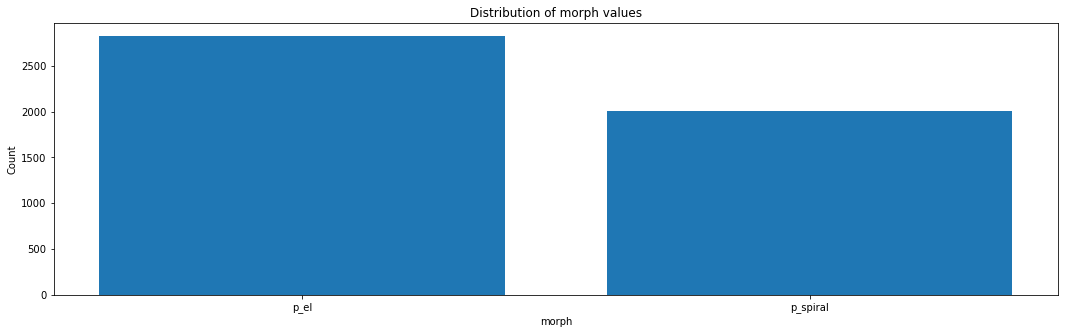

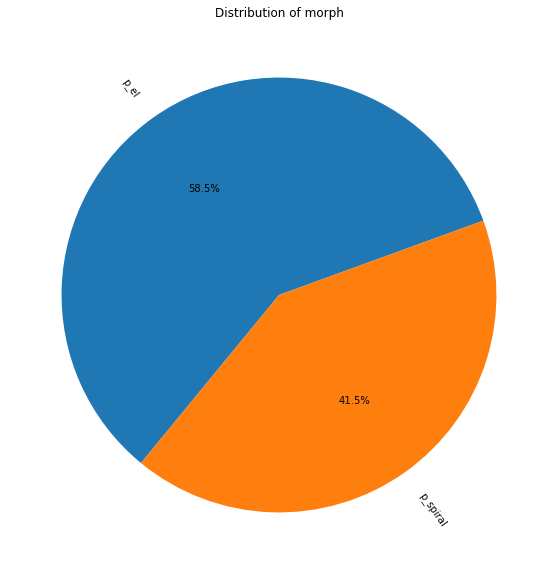

In [9]:
col = 'morph'
vals,counts = utils.get_categorical_frequencies(table.data, table.column_names.index("morph"))
plot_utils.categorical_frequency_bar_plot(col, vals, counts)
plot_utils.categorical_frequency_pie_plot(col, vals, counts)

To remedy the class imbalance issue, we simply drop 600 instances from the 'p_el' instance set to achieve a rough 50/50 split of 'p_el' and 'p_spiral.'

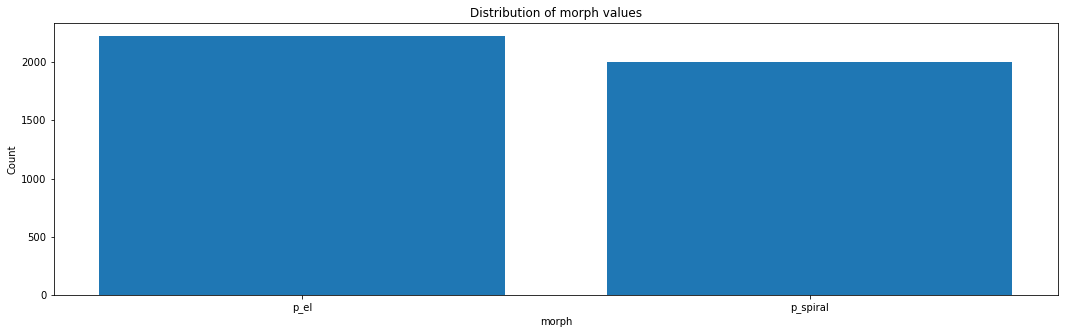

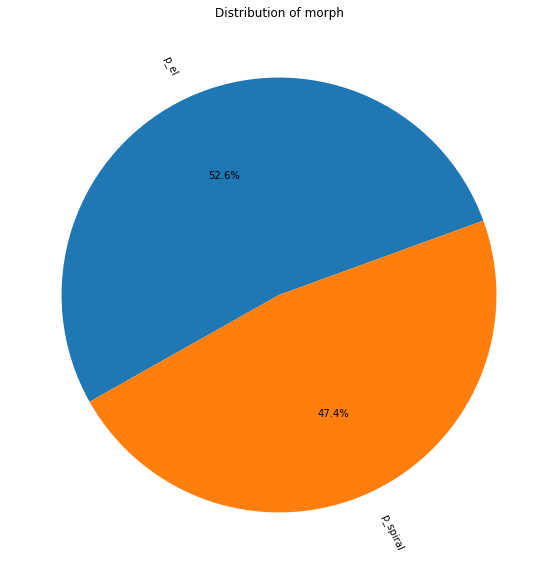

In [10]:
el_to_drop = 600 # multi-class 1000, 600 binary
morph_index = table.column_names.index('morph')
j = 0
i = 0
while i < el_to_drop:
    if table.data[j][morph_index] == 'p_el':
        table.data.pop(j)
        i += 1
    j += 1
    
vals,counts = utils.get_categorical_frequencies(table.data, table.column_names.index("morph"))
plot_utils.categorical_frequency_bar_plot(col, vals, counts)
plot_utils.categorical_frequency_pie_plot(col, vals, counts)

### Features of Interest
We utilize again EDA to look into whether or not there were any features within the dataset that have high or low correlations with other attributes/class labels so as to gain intuition for potential pruning strategies or attributes to eliminate to reduce overfitting. From the bar charts below, there is no significance between the attributes plotted and the class labels. Rather, the bar charts of ra (right ascenscion) and dec (declination) indicate the swath of the sky the observations in SDSS dataset originate. In our course, the charts show the observations stem from a 360 degree halo of sky. As for the z (redshift) bar chart, z provides intution as to how far away the galaxies are within the SDSS dataset. A redshift less than one is relatively close to our own Milky Way. 

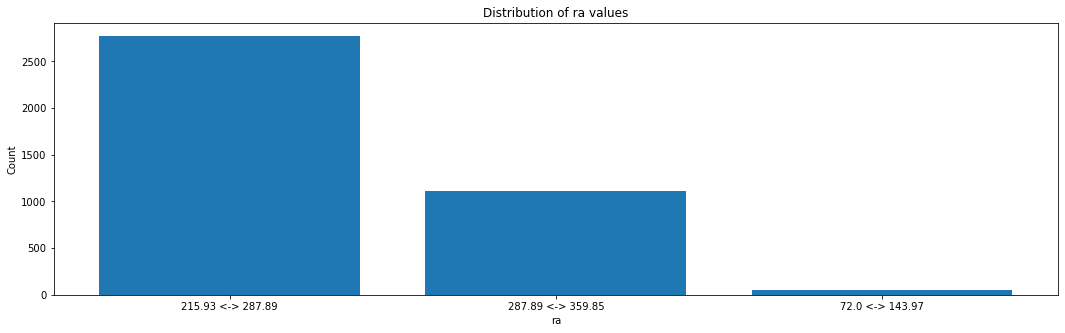

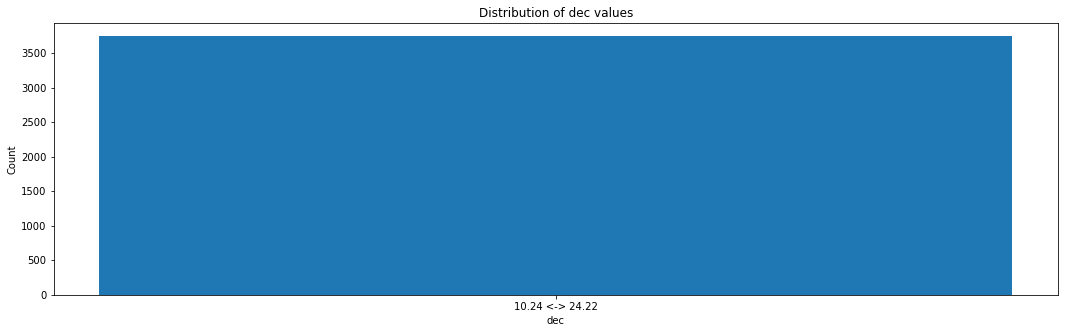

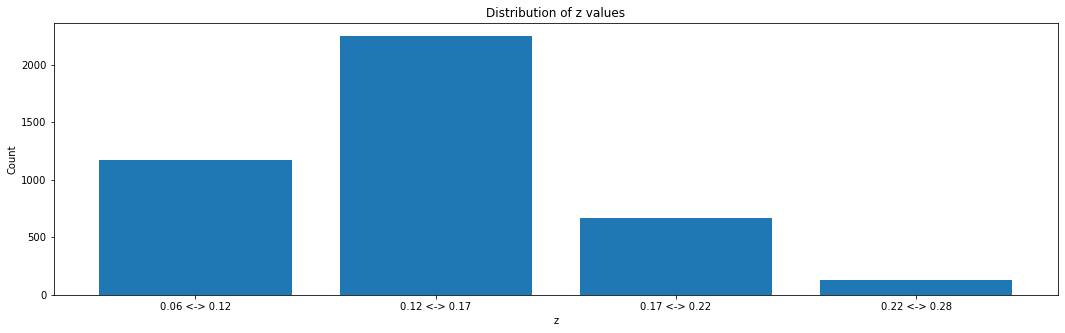

In [12]:
fluxs = ['h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux', 'h_alpha_flux', 'nii_6548_flux', 'sii_6717_flux', 'sii_6731_flux']
flux_col_idxs = [table.column_names.index(flux) for flux in fluxs]
table.data = [[int(row[i]) if i in flux_col_idxs else row[i] for i in range(len(row))] for row in table.data]


rows_to_drop = []
for i in range(len(table.data)):
    for j in range(len(table.data[i])):
        if j in flux_col_idxs:
            if table.data[i][j] < -1*10**5 or table.data[i][j] > 1*10**5:
                rows_to_drop.append(i)
            
table.drop_rows(rows_to_drop)



cols = ['ra', 'dec', 'z'] 
importlib.reload(utils)
importlib.reload(plot_utils)
for column in cols:
    col = table.get_column(column, False)
    edges = utils.compute_equal_width_cutoffs(col, 5)
    labels = [str(edges[i]) +' <-> ' +str(edges[i+1]) for i in range(5)]
    range_array = utils.range_discretization(edges, labels, table.data, table.column_names, column)
    ranges,cts = utils.get_array_frequencies(range_array)
    plot_utils.categorical_frequency_bar_plot(column, ranges, cts)

### Distribution of Fluxes Measured from the Galactic Spectra
In order to better understand the distribution of fluxes, a box and whisker plot indicate various flux outliers.

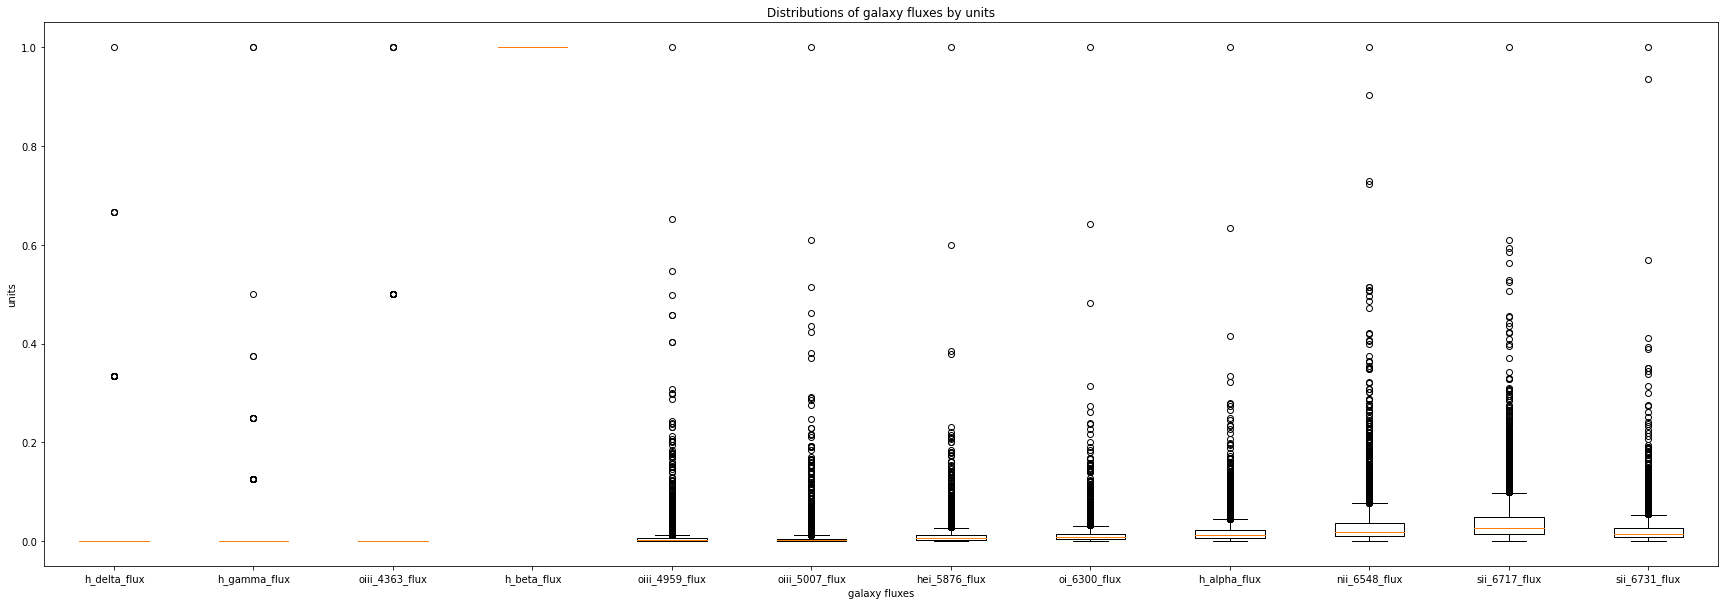

In [13]:
scaled_cols = ['dec', 'ra', 'waveMin', 'plateSN2','h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux', 'h_alpha_flux', 'nii_6548_flux', 'sii_6717_flux', 'sii_6731_flux']
scaled_col_idxs = [table.column_names.index(col) for col in scaled_cols] # , 'h_beta_flux' removed from scaled cols as it will divide by zero
for flux_col_idx in flux_col_idxs:
    table.data = [row for row in table.data if row[flux_col_idx] < 5*10**6]
col_vals = []

for i in range(len(table.data[0])):
    if i in scaled_col_idxs:
        col = table.get_column(table.column_names[i])
        col_vals.append([min(col), max(col)])
    else:
        col_vals.append([1,1])

for i in range(len(table.data)):
    for j in range(len(table.data[i])):
        if j in scaled_col_idxs:
            table.data[i][j] = (table.data[i][j] - col_vals[j][0]) / (col_vals[j][1] - col_vals[j][0])
dists = []
for flux in fluxs:
    col = table.get_column(flux)
    dists.append(col)

plot_utils.box_plot_example(dists, fluxs, ['galaxy fluxes', 'units'])

We might want to further filter down the rows which have outliers for these fluxes as they could be hard for our model to generalize. The next code snippet eliminates the following columns 'specObjID', 'plate', 'mjd', 'fiberID', 'zWarning', 'class', 'h_beta_flux', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'waveMin', 'plateSN2', 'z', 'ra', and 'dec' as they provide little to know information in the classification set. 

In [14]:
cols_to_remove = ['specObjID', 'plate', 'mjd', 'fiberID', 'zWarning', 'class', 'h_beta_flux'] 
target_vals = table.get_column('morph')
table.drop_cols(cols_to_remove)

cols_to_remove = ['h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'waveMin', 'plateSN2', 'z', 'ra', 'dec'] 
table.drop_cols(cols_to_remove)

table.save_to_file('data_continuous.csv')

Recalibrating the the box and whisker plots with the removed columns:

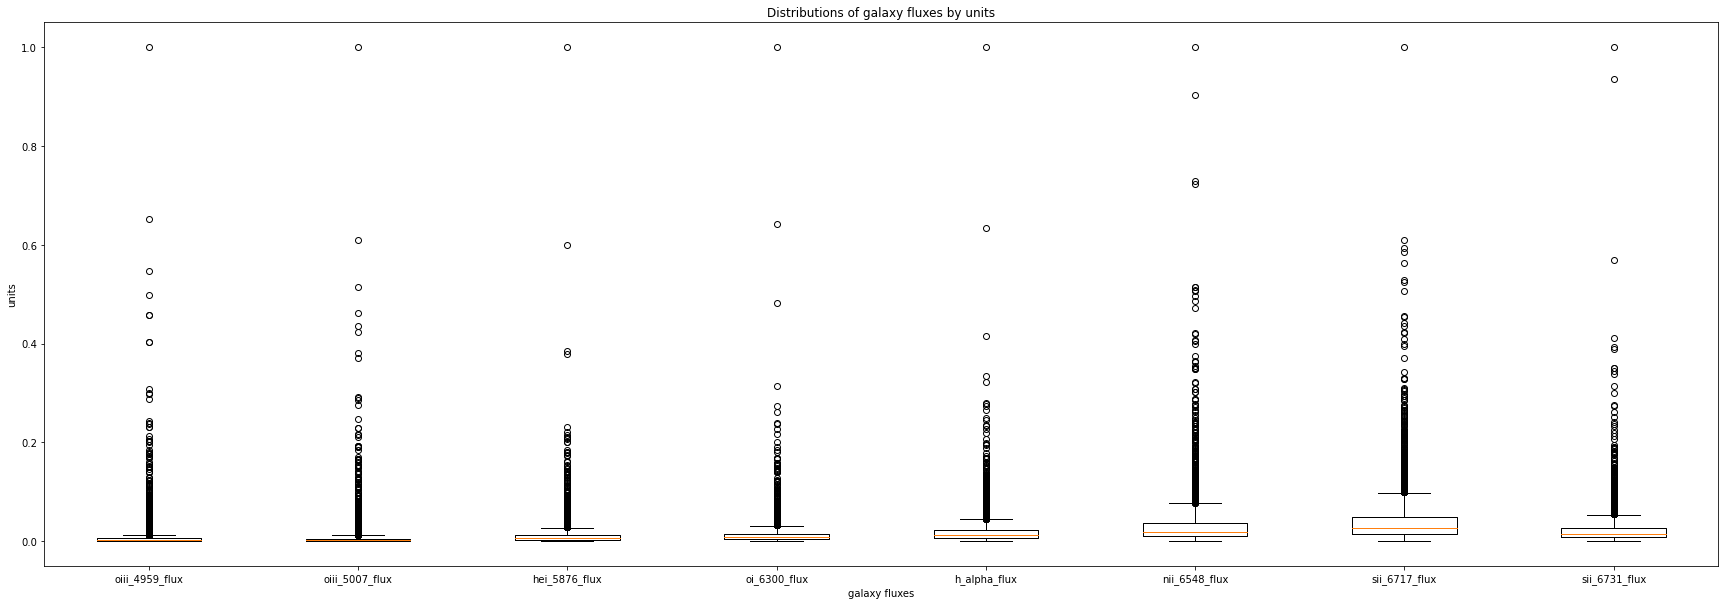

In [17]:
dists = []
for flux in table.column_names[:len(table.column_names) - 1]:
    col = table.get_column(flux)
    dists.append(col)

plot_utils.box_plot_example(dists, table.column_names[:len(table.column_names) - 1], ['galaxy fluxes', 'units'])

After min-maxing the fluxes, we generate the following frequency diagrams for each of the remaining fluxes. The left-skewed nature of the frequency diagrams indicates the dominance of larger fluxes. Thus, removing the higher ends of the fluxes may aid in increasing the accuracy of our classifiers. 

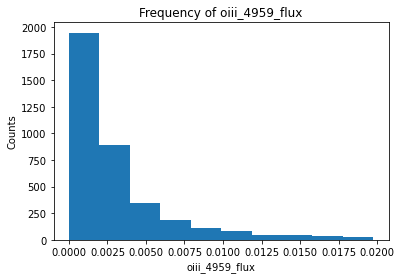

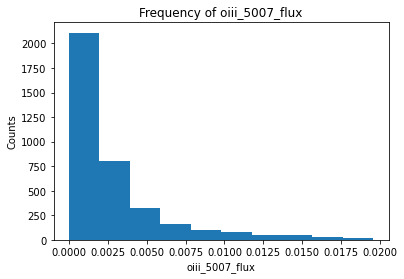

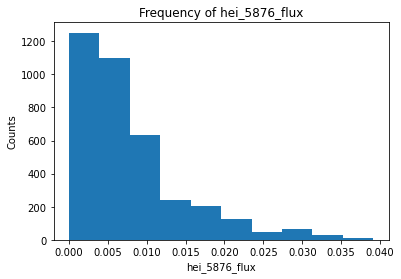

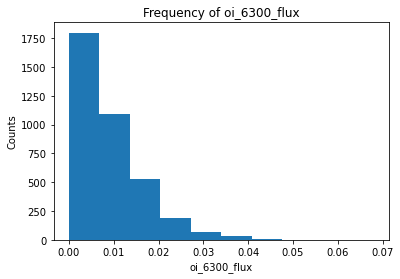

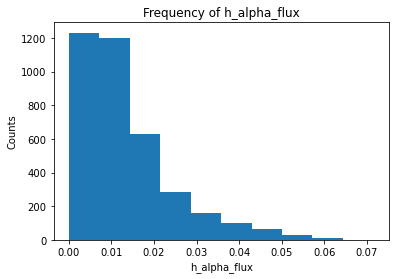

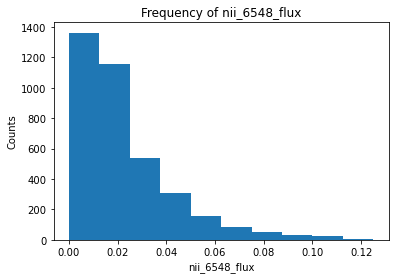

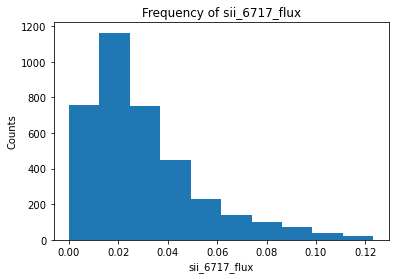

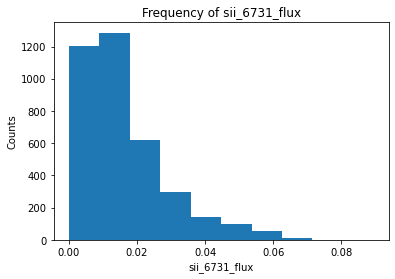

In [18]:
cols = table.column_names[:-1]

rows_to_drop = []
maxs = [0.02, 0.02, 0.04, 0.075, 0.1, 0.125, 0.125, 0.125]
for i in range(len(table.data)):
    drop = False
    for j in range(len(cols)):
        if table.data[i][j] > maxs[j]:
            drop = True
    if drop:
        rows_to_drop.append(i)

table.drop_rows(rows_to_drop)
plot_utils.plot_hist(table, cols)

### Discretization 
For the sake of catergorical classifiers, we opted to discretize our data within five bins as shown in the code below.

In [21]:
col_ranges = [[[-1, 0.00125, 0.0025, 0.005, 0.0075, 1],[0, 1,2,3,4, 5]], [[-1, 0.00125, 0.0025, 0.005, 0.0075, 1],[0,1,2,3,4,5]], [[-1, 0.00125, 0.0025, 0.005, 0.0075,1],[0, 1,2,3,4,5]], [[-1, 0.005, 0.01, 0.02, 0.03,1],[0, 1,2,3,4,5]], [[-1, 0.005, 0.01, 0.02, 0.03, 1],[0, 1,2,3,4,5]], [[-1, 0.01, 0.02, 0.03, 0.04,1],[0, 1,2,3,4,5]], [[-1, 0.01, 0.02, 0.03, 0.04, 1],[0, 1,2,3,4, 5]], [[-1, 0.01, 0.02, 0.03, 0.04, 1],[0, 1,2,3,4, 5]]]
discs = []
for col in cols:
    print(len(table.get_column(col)))
for i in range(len(cols)):
    disc = utils.range_discretization(col_ranges[i][0], col_ranges[i][1], table.data, table.column_names, cols[i])
    discs.append(disc)

for i in range(len(table.data)):
    for j in range(len(cols)):
        table.data[i][j] = discs[j][i]

3719
3719
3719
3719
3719
3719
3719
3719


IndexError: list index out of range

In [20]:
for i in range(len(cols)):
    vals, counts = utils.get_frequencies(table.data, i)
    print(cols[i], ' : ', vals, counts)
table.save_to_file('data_discretized.csv')

oiii_4959_flux  :  [1, 2, 3, 4, 5] [1050, 1122, 866, 309, 372]
oiii_5007_flux  :  [1, 2, 3, 4, 5] [1385, 1024, 696, 267, 347]
hei_5876_flux  :  [1, 2, 3, 4, 5] [359, 436, 873, 684, 1367]
oi_6300_flux  :  [1, 2, 3, 4, 5] [1049, 1299, 1007, 284, 80]
h_alpha_flux  :  [1, 2, 3, 4, 5] [749, 1073, 1153, 414, 330]
nii_6548_flux  :  [1, 2, 3, 4, 5] [1040, 1133, 613, 338, 595]
sii_6717_flux  :  [1, 2, 3, 4, 5] [517, 1041, 751, 494, 916]
sii_6731_flux  :  [1, 2, 3, 4, 5] [1415, 1270, 556, 246, 232]


## Classification Results
For classification we utilize the following classifiers -- kNN, Naive Bayes, Decision Tree, Random Forest, and Dummy. Our primary measure of classifier performance is accuracy. With the code snippets below, each snippet prints the results of all the classifiers. However, due to computational limitations, the kNN classifier uses a set of only 2,000 instances as opposed to the full dataset of roughly 4,000 instances. 

In [ ]:
cont_table = MyPyTable()
disc_table = MyPyTable()

cont_table.load_from_file('data_continuous.csv')
disc_table.load_from_file('data_discretized.csv')

cont_target_vals = cont_table.get_column('morph')
cont_table.drop_cols(['morph'])

disc_target_vals = disc_table.get_column('morph')
disc_table.drop_cols(['morph'])

In [ ]:
# Discretized
X_train_idx_folds, X_test_idx_folds = myevaluation.stratified_kfold_cross_validation(
    disc_table.data, disc_target_vals, n_splits=7)

X_train = [[disc_table.data[idx] for idx in fold] for fold in X_train_idx_folds]
y_train = [[disc_target_vals[idx] for idx in fold]
            for fold in X_train_idx_folds]
X_test = [[disc_table.data[idx] for idx in fold] for fold in X_test_idx_folds]
y_test = [[disc_target_vals[idx] for idx in fold]
            for fold in X_test_idx_folds]

knn = MyKNeighborsClassifier(3)
dummy = MyDummyClassifier()
# bayes = MyNaiveBayesClassifier()
dec_tree = MyDecisionTreeClassifier()
forest = MyRandomForestClassifier()

classifier_names = ['dummy', 'dec_tree', 'forest']
models = [dummy, dec_tree, forest]
preds = [[] for _ in models]

forest.F = 3
forest.M = 50
forest.N = 21

for i in range(len(X_train)):
    for j in range(len(models)):
        models[j].fit(X_train[i], y_train[i])
        preds[j] += models[j].predict(X_test[i])

y_test = list(chain.from_iterable(y_test))

for i in range(len(preds)):
    myevaluation.cross_val_stats(classifier_names[i], y_test, preds[i])

In [ ]:
# Continuous 
X_train_idx_folds, X_test_idx_folds = myevaluation.stratified_kfold_cross_validation(
    cont_table.data, cont_target_vals, n_splits=7)

X_train = [[cont_table.data[idx] for idx in fold] for fold in X_train_idx_folds]
y_train = [[cont_target_vals[idx] for idx in fold]
            for fold in X_train_idx_folds]
X_test = [[cont_table.data[idx] for idx in fold] for fold in X_test_idx_folds]
y_test = [[cont_target_vals[idx] for idx in fold]
            for fold in X_test_idx_folds]

# knn = MyKNeighborsClassifier(3)
dummy = MyDummyClassifier()
bayes = MyNaiveBayesClassifier()
# dec_tree = MyDecisionTreeClassifier()

classifier_names = ['dummy', 'bayes']
models = [dummy, bayes]
preds = [[] for _ in models]

for i in range(len(X_train)):
    # print('i', i)
    for j in range(len(models)):
        # print('j', j)
        models[j].fit(X_train[i], y_train[i])
        preds[j] += models[j].predict(X_test[i])

y_test = list(chain.from_iterable(y_test))

for i in range(len(preds)):
    if classifier_names[i] == 'bayes':
        preds[i] = bayes.convert_idxs_to_class_labels(y_test, preds[i])
        myevaluation.cross_val_stats(classifier_names[i], y_test, preds[i])
    else:
        myevaluation.cross_val_stats(classifier_names[i], y_test, preds[i])

In [ ]:
# Continuous kNN down selection 
utils.randomize_in_place(cont_table.data, cont_target_vals)
cont_table_copy = cont_table.data.copy()
cont_table_copy = cont_table_copy[:2001]
X_train_idx_folds, X_test_idx_folds = myevaluation.stratified_kfold_cross_validation(
    cont_table_copy, cont_target_vals, n_splits=7)

X_train = [[cont_table_copy[idx] for idx in fold] for fold in X_train_idx_folds]
y_train = [[cont_target_vals[idx] for idx in fold]
            for fold in X_train_idx_folds]
X_test = [[cont_table_copy[idx] for idx in fold] for fold in X_test_idx_folds]
y_test = [[cont_target_vals[idx] for idx in fold]
            for fold in X_test_idx_folds]

knn = MyKNeighborsClassifier(5)
# dummy = MyDummyClassifier()
# bayes = MyNaiveBayesClassifier()
# dec_tree = MyDecisionTreeClassifier()

classifier_names = ['dummy', 'knn']
models = [dummy, knn]
preds = [[] for _ in models]

for i in range(len(X_train)):
    # print('i', i)
    for j in range(len(models)):
        # print('j', j)
        models[j].fit(X_train[i], y_train[i])
        preds[j] += models[j].predict(X_test[i])

y_test = list(chain.from_iterable(y_test))

for i in range(len(preds)):
    myevaluation.cross_val_stats(classifier_names[i], y_test, preds[i])

Ultimately, kNN performs the best out of all classifiers with an accuracy of 71.2 % which makes sense as the attributes are best in their float form. 

## Summary 
With a simple SQL search targeting galatic morphologies and fluxes from galactic emission spectra from the [Sloan Digital Sky Survey](https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+zooSpec+U) (SDSS), one can amass a dataset with tens of thousands of instances. Sadly, in the heat of creating the SDSS dataset, someone (Logan) forgot to save the SQL query. However, such a query is easily reproducible. To save computing power, one can limit the number of instances to 20,000 before data cleaning. Following data cleaning, the number of instances drops to roughly 4,000. The main objective of classifying galatic morphologies using fluxes from the SDSS dataset is to improve the speed at which astronomers may parse through spectra. By testing classifiers such as kNN, Naive Bayes, Decision Tree, Random Forest, and Dummy, an accuracy test proves kNN to be the best classifier. Unfortunately though, kNN requires the most computational power, so the number of instances must drop to 2,000 for a reasonable computational time. 